# Demo: Chirp mass distribution of binary black holes (BBHs)

This notebook reproduces Figure 10 of the COMPAS Paper (_arXiv_: ; Mandel et al., in prep.) using the file COMPAS_CHE_30xZ_3000000.h5, which can be downloaded from the [COMPAS Zenodo community](https://zenodo.org/communities/compas/?page=1&size=20).

This file contains the output of 3,000,000 binaries evolved using COMPAS v02.11.01a (v02.11.01 plus fix for issue #260) with the Fidicuial Model (Mandel et al., in prep.) over 30 different metallicities, uniform in $\log(Z) \in [10^{-4},10^{-1.825}]$. More details can be found in `Run_Details.txt`.

We include some comments to clarify different parts of the code below. But for a full exposition to COMPAS's post-processing tools, please work through the Jupyter Notebook tutorials in the `postProcessing` directory.

## Paths and libraries
* If you would like to use this script for your own COMPAS Output, you can change `fileName`.

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

COMPASdir = os.environ['COMPAS_ROOT_DIR']
pathScripts = COMPASdir + "/postProcessing/Folders/CosmicIntegration/PythonScripts/"
pathData = COMPASdir + "/docs/demo/"
fileName = "COMPAS_CHE_30xZ_3000000.h5"

sys.path.append(pathScripts)
import ClassCosmicIntegrator

# Importing ClassCosmicIntegrator imports other classes, including ClassCOMPAS,
# ClassMSSFR, selection_effects, totalMassEvolvedPerZ. 

## Create instance of ClassCosmicIntegrator

In [2]:
CI = ClassCosmicIntegrator.CosmicIntegrator(pathCOMPAS=pathData, fileName=fileName)

reminders of what to set in the following order:

ClassCOMPAS: Remember to self.setGridAndMassEvolved() [optional]
                   then  self.setCOMPASDCOmask()
                   then  self.setCOMPASData()
ClassMSSFR: Remember to set self.SFRprescription() + subparts
                            self.Zprescription()   +sub-parts
                            set self.calculateMetallicityBinEdges()
ClassCosmicIntegrator: Remember to setBirthTimesAnd2Darrays()
                        to prepare calculation/results
                        do you have the GW-detector you want?


## Set the COMPAS class in our cosmicIntegrator

In [3]:
# Set lower and upper mass limits used for Kroupa IMF when drawing ZAMS stars in the COMPAS run
CI.COMPAS.Mlower = 5.0
CI.COMPAS.Mupper = 150.0

CI.COMPAS.binaryFraction = 0.7

CI.COMPAS.setGridAndMassEvolved()
CI.COMPAS.setCOMPASDCOmask()  # By default, this masks for BBHs formed under the pessimistic CE assumption
CI.COMPAS.setCOMPASData()  # This carries out the mask

## Specify the MSSFR model

In [5]:
CI.MSSFR.SFRprescription = "Neijssel et al. (2019)"
CI.MSSFR.Zprescription = "logNormal"
CI.MSSFR.logNormalPrescription = "Neijssel Phenomenological"

# Set the metallicity grid from the COMPAS output
CI.MSSFR.metallicityGrid = CI.COMPAS.metallicityGrid
CI.MSSFR.calculateMetallicityBinEdges()
CI.setBirthTimesAnd2Darrays() 

## Perform the cosmic integration

In [6]:
CI.cosmologicalIntegration()

## Create chirp mass distribution

In [10]:
chirpMass = CI.COMPAS.mChirp
ratePerSys_observed = np.sum(CI.PerSystemPerRedshift_ratesObserved, axis=0)
mask = chirpMass < 100 # Set maximum plotted chirp mass to be 100 Msun

# Set grid in chirp mass
binsMchirp = np.linspace(0, 40, 20)
dMchirp = np.diff(binsMchirp)
center = (binsMchirp[1:] + binsMchirp[:-1]) / 2.0

yvalues, _ = np.histogram(chirpMass[mask], bins=binsMchirp, weights=ratePerSys_observed[mask])
dydMchirp = np.divide(yvalues, dMchirp)

## Plot chirp mass distribution

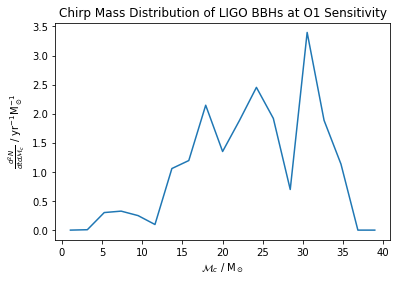

In [11]:
fig, axes = plt.subplots(1, 1)
axes.plot(center, dydMchirp)
plt.title("Chirp Mass Distribution of LIGO BBHs at O1 Sensitivity")
axes.set_xlabel("$\mathcal{M}_c}$ / $\mathrm{M}_\odot$")
axes.set_ylabel("$\\frac{d^2N}{dtd\mathcal{M}_c}$ / $\mathrm{yr}^{-1}\mathrm{M}_\odot^{-1}$")
plt.show()